In [1]:
# Import libraries
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models import vgg16, VGG16_Weights
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from sklearn.model_selection import KFold
from tqdm import tqdm 
import numpy as np
import warnings
import pandas as pd
from PIL import Image
import torchvision.transforms.functional as TF

In [5]:
# Define target image size and batch size
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 64

# Convert resized images to tensors and normalize pixel values
data_transforms = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load training and test datasets (no augmentation)
train_dataset = datasets.ImageFolder(root=train_dir, transform=data_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=data_transforms)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [17]:
def extract_features(model, dataloader):
    features = []
    labels = []
    # Use tqdm to create a progress bar for the loop
    for images, targets in tqdm(dataloader, desc='Extracting features', unit='batch'):
        with torch.no_grad():
            extracted_features = model(images)
            features.append(extracted_features)
            labels.append(targets)
    return torch.cat(features), torch.cat(labels)


In [35]:
from torchvision.models import vgg16
weights = VGG16_Weights.IMAGENET1K_V1
vgg = vgg16(weights=weights) # Initialize VGG16 model with pre-trained weights
vgg.eval() # disables features like dropout and batch normalization updates
vgg.trainable = False # Freeze the parameters of the VGG16 model

to_predict = vgg(torch.unsqueeze(data_transforms(Image.open('topredict/test.jpg')), 0))

In [ ]:
# Load datasets (1000 features)
train_features = torch.load('train_features.pth')
train_labels = torch.load('train_labels.pth')
test_features = torch.load('test_features.pth')
test_labels = torch.load('test_labels.pth')

train_labels = train_labels.float()
test_labels = test_labels.float()

final_hidden_neurons = 512
final_dropout_rate = 0.3
final_learning_rate = 0.001
final_weight_decay = 0.000001
final_num_epochs = 80

model = cats_vs_dogs(input_size, hidden_size=final_hidden_neurons, output_size=output_size, dropout=final_dropout_rate)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=final_learning_rate, weight_decay=final_weight_decay)

for epoch in range(79):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_features)
    loss = criterion(outputs, train_labels.unsqueeze(1))  # BCELoss expects 2D output
    loss.backward()
    optimizer.step()

    # Evaluate each epoch for early stopping
    model.eval()
    with torch.no_grad():
        test_outputs = model(test_features)
        test_loss = criterion(test_outputs, test_labels.unsqueeze(1))
        test_predictions = (test_outputs >= 0.5).float()
        test_accuracy = (test_predictions == test_labels.unsqueeze(1)).float().mean().item()
        
# Print the accuracy and loss at the final epoch
print(f"Final Test Loss: {test_loss.item()}, Final Test Accuracy: {test_accuracy}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


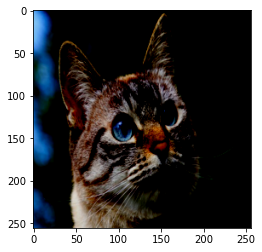

In [26]:
plt.imshow(  data_transforms(Image.open('topredict/test.jpg')).permute(1, 2, 0)  )

In [6]:
# Pytorch automatically assigns labels to the images based on the directory names
classes = train_dataset.classes
print(classes)

['cats', 'dogs']


I was thinking, maybe it's smarter to do the feature extraction outside of the model. Otherwise it will have to repeat this each time.

In [2]:
from torchvision.models import vgg16
from tqdm import tqdm  # Import tqdm for progress bar

def extract_features(model, dataloader):
    features = []
    labels = []
    # Use tqdm to create a progress bar for the loop
    for images, targets in tqdm(dataloader, desc='Extracting features', unit='batch'):
        with torch.no_grad():
            extracted_features = model(images)
            features.append(extracted_features)
            labels.append(targets)
    return torch.cat(features), torch.cat(labels)

# Import VGG16 model with pre-trained weights
weights = VGG16_Weights.IMAGENET1K_V1
vgg = vgg16(weights=weights) # Initialize VGG16 model with pre-trained weights
vgg.eval() # disables features like dropout and batch normalization updates
vgg.trainable = False # Freeze the parameters of the VGG16 model

# Extract features from training data
train_features, train_labels = extract_features(vgg, train_loader)

# Extract features from test data
test_features, test_labels = extract_features(vgg, test_loader)


NameError: name 'train_loader' is not defined

In [ ]:
train_dataset = datasets.ImageFolder(root=train_dir, transform=data_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=data_transforms)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [17]:
# Save extracted training features and labels
torch.save(train_features, 'train_features.pth')
torch.save(train_labels, 'train_labels.pth')

# Save extracted test features and labels
torch.save(test_features, 'test_features.pth')
torch.save(test_labels, 'test_labels.pth')

### Hyperparameter Search

In [4]:
# Load datasets (1000 features)
train_features = torch.load('train_features.pth')
train_labels = torch.load('train_labels.pth')
test_features = torch.load('test_features.pth')
test_labels = torch.load('test_labels.pth')

In [5]:
print("Train features shape:", train_features.shape)
print("Train labels shape:", train_labels.shape)
print("Test features shape:", test_features.shape)
print("Test labels shape:", test_labels.shape)

Train features shape: torch.Size([20000, 1000])
Train labels shape: torch.Size([20000])
Test features shape: torch.Size([5000, 1000])
Test labels shape: torch.Size([5000])


In [16]:
class cats_vs_dogs(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout):
        super(cats_vs_dogs, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.output = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

In [17]:
input_size = train_features.shape[1]
output_size = 1
num_epochs = 100
batch_size = 32
early_stopping_patience = 5 

# define hyperparameters to test
hidden_sizes = [64, 128, 512]
dropout_rates = [0.1, 0.2, 0.3] 
learning_rates = [0.001, 0.01, 0.1] 
weight_decays = [1e-4, 1e-5, 1e-6] 

In [32]:
# Suppress the warning
warnings.filterwarnings("ignore", category=UserWarning)

# Create the KFold object
np.random.seed(42)
kf = KFold(n_splits=5, shuffle=True)

# Create lists to store results
hidden_neurons_list = []
dropout_rate_list = []
learning_rate_list = []
weight_decay_list = []
fold_accuracies_list = []
fold_losses_list = []
avg_accuracies_list = []
avg_losses_list = []

# Cross-validation loop
for hidden_neurons in hidden_sizes:
    for dropout_rate in dropout_rates:
        for learning_rate in learning_rates:
            for weight_decay in weight_decays:
                print(f"Training with hidden neurons:{hidden_neurons}, dropout: {dropout_rate}, learning rate: {learning_rate}, weight decay: {weight_decay}")

                fold_accuracies = []
                fold_losses = []

                # Initialize neural network
                model = cats_vs_dogs(input_size, hidden_size=hidden_neurons, output_size=output_size, dropout=dropout_rate)

                # Define loss function and optimizer
                criterion = nn.BCELoss()
                optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

                # K-Fold cross-validation
                for train_index, val_index in kf.split(train_features):
                    train_X, val_X = train_features[train_index], train_features[val_index]
                    train_Y, val_Y = train_labels[train_index], train_labels[val_index]

                    # Convert numpy arrays to PyTorch tensors
                    train_X = torch.tensor(train_X.clone().detach(), dtype=torch.float32)
                    val_X = torch.tensor(val_X.clone().detach(), dtype=torch.float32)
                    train_Y = torch.tensor(train_Y.clone().detach(), dtype=torch.float32)
                    val_Y = torch.tensor(val_Y.clone().detach(), dtype=torch.float32)

                    # For early stopping
                    best_val_loss = float('inf')
                    no_improvement_count = 0

                    # Train the model
                    for epoch in range(num_epochs):
                        model.train()
                        optimizer.zero_grad()
                        outputs = model(train_X)
                        loss = criterion(outputs, train_Y.unsqueeze(1))  # BCELoss expects 2D output
                        loss.backward()
                        optimizer.step()

                        # Evaluate each epoch for early stopping
                        model.eval()
                        with torch.no_grad():
                            val_outputs = model(val_X)
                            val_loss = criterion(val_outputs, val_Y.unsqueeze(1))

                            if val_loss < best_val_loss:
                                best_val_loss = val_loss
                                no_improvement_count = 0
                            else:
                                no_improvement_count += 1

                            if no_improvement_count >= early_stopping_patience:
                                break

                    # Evaluate on validation set after training
                    model.eval()
                    with torch.no_grad():
                        val_outputs = model(val_X)
                        val_loss = criterion(val_outputs, val_Y.unsqueeze(1))
                        val_predictions = (val_outputs >= 0.5).float()
                        val_accuracy = (val_predictions == val_Y.unsqueeze(1)).float().mean().item()

                        fold_accuracies.append(val_accuracy)
                        fold_losses.append(val_loss.item())

                avg_accuracy = np.mean(fold_accuracies)
                avg_loss = np.mean(fold_losses)

                # Append results to lists
                hidden_neurons_list.append(hidden_neurons)
                dropout_rate_list.append(dropout_rate)
                learning_rate_list.append(learning_rate)
                weight_decay_list.append(weight_decay)
                fold_accuracies_list.append(fold_accuracies)
                fold_losses_list.append(fold_losses)
                avg_accuracies_list.append(avg_accuracy)
                avg_losses_list.append(avg_loss)

# Create DataFrame
results_df = pd.DataFrame({
    "Hidden Neurons": hidden_neurons_list,
    "Dropout Rate": dropout_rate_list,
    "Learning Rate": learning_rate_list,
    "Weight Decay": weight_decay_list,
    "Fold Accuracies": fold_accuracies_list,
    "Fold Losses": fold_losses_list,
    "Average Accuracy": avg_accuracies_list,
    "Average Loss": avg_losses_list
})

# Save DataFrame to a CSV file
results_df.to_csv('results_hyperparameter_search.csv', index=False)

Training with hidden neurons:64, dropout: 0.1, learning rate: 0.001, weight decay: 0.0001
Training with hidden neurons:64, dropout: 0.1, learning rate: 0.001, weight decay: 1e-05
Training with hidden neurons:64, dropout: 0.1, learning rate: 0.001, weight decay: 1e-06
Training with hidden neurons:64, dropout: 0.1, learning rate: 0.01, weight decay: 0.0001
Training with hidden neurons:64, dropout: 0.1, learning rate: 0.01, weight decay: 1e-05
Training with hidden neurons:64, dropout: 0.1, learning rate: 0.01, weight decay: 1e-06
Training with hidden neurons:64, dropout: 0.1, learning rate: 0.1, weight decay: 0.0001
Training with hidden neurons:64, dropout: 0.1, learning rate: 0.1, weight decay: 1e-05
Training with hidden neurons:64, dropout: 0.1, learning rate: 0.1, weight decay: 1e-06
Training with hidden neurons:64, dropout: 0.2, learning rate: 0.001, weight decay: 0.0001
Training with hidden neurons:64, dropout: 0.2, learning rate: 0.001, weight decay: 1e-05
Training with hidden neuro

In [33]:
ordered_results = results_df.sort_values(by='Average Accuracy', ascending=False)
results_df.to_csv('ordered_results_hyperparameter_search.csv', index=False)

In [34]:
print(ordered_results.head(10))

    Hidden Neurons  Dropout Rate  Learning Rate  Weight Decay  \
74             512           0.3          0.001      0.000001   
63             512           0.2          0.001      0.000100   
72             512           0.3          0.001      0.000100   
55             512           0.1          0.001      0.000010   
36             128           0.2          0.001      0.000100   
29             128           0.1          0.001      0.000001   
37             128           0.2          0.001      0.000010   
28             128           0.1          0.001      0.000010   
65             512           0.2          0.001      0.000001   
64             512           0.2          0.001      0.000010   

                                      Fold Accuracies  \
74  [0.987500011920929, 0.9950000047683716, 0.9942...   
63  [0.9890000224113464, 0.9944999814033508, 0.990...   
72  [0.9822499752044678, 0.9909999966621399, 0.992...   
55  [0.9857500195503235, 0.987500011920929, 0.9934...   

In [42]:
print(ordered_results.iloc[0])
print(ordered_results.iloc[0]["Fold Accuracies"])
print(ordered_results.iloc[0]["Fold Losses"])

Hidden Neurons                                                    512
Dropout Rate                                                      0.3
Learning Rate                                                   0.001
Weight Decay                                                 0.000001
Fold Accuracies     [0.987500011920929, 0.9950000047683716, 0.9942...
Fold Losses         [0.03587726876139641, 0.019996246322989464, 0....
Average Accuracy                                               0.9933
Average Loss                                                 0.021804
Name: 74, dtype: object
[0.987500011920929, 0.9950000047683716, 0.9942499995231628, 0.9947500228881836, 0.9950000047683716]
[0.03587726876139641, 0.019996246322989464, 0.018080344423651695, 0.017463911324739456, 0.017603423446416855]


### Determining the number of epochs

In [50]:
final_hidden_neurons = 512
final_dropout_rate = 0.3
final_learning_rate = 0.001
final_weight_decay = 0.000001

To know at which epoch we have to stop the training, I split the training set into training set and validation set and print the validation loss/accuracy at each epoch.

In [56]:
torch.manual_seed(42)

# Load datasets
train_features = torch.load('train_features.pth')
train_labels = torch.load('train_labels.pth')

# Determine the size of the validation set
val_size = int(0.2 * len(train_features))

# Shuffle the indices to randomize the data
indices = torch.randperm(len(train_features))

# Split the shuffled indices into training and validation sets
train_indices = indices[val_size:]
val_indices = indices[:val_size]

# Use the shuffled indices to get shuffled training and validation sets
train_X, val_X = train_features[train_indices], train_features[val_indices]
train_Y, val_Y = train_labels[train_indices], train_labels[val_indices]

train_Y = train_Y.float()
val_Y = val_Y.float()

Train model for 400 epochs and print validation loss/accuracy at each epoch:

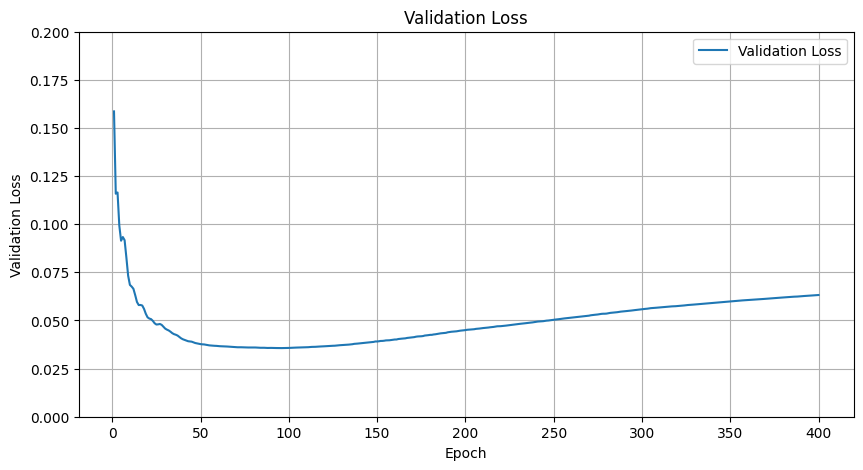

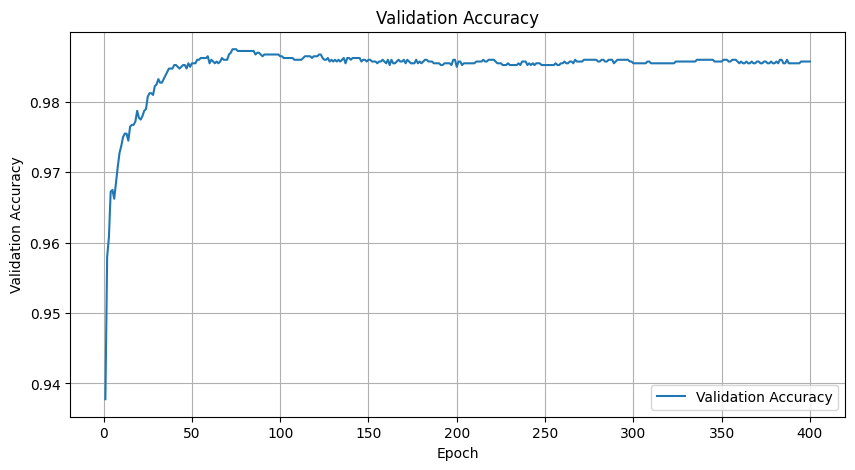

In [60]:
val_losses = []
val_accuracies = []

model = cats_vs_dogs(input_size, hidden_size=final_hidden_neurons, output_size=output_size, dropout=final_dropout_rate)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=final_learning_rate, weight_decay=final_weight_decay)

for epoch in range(400):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_X)
    loss = criterion(outputs, train_Y.unsqueeze(1))  # BCELoss expects 2D output
    loss.backward()
    optimizer.step()

    # Evaluate each epoch for early stopping
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_X)
        val_loss = criterion(val_outputs, val_Y.unsqueeze(1))
        val_predictions = (val_outputs >= 0.5).float()
        val_accuracy = (val_predictions == val_Y.unsqueeze(1)).float().mean().item()
        
        val_losses.append(val_loss.item())
        val_accuracies.append(val_accuracy)

# Plot validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, 401), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss')
plt.legend()
plt.grid(True)
plt.ylim(0, 0.2)  # Set y-axis limits
plt.show()


# Plot validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, 401), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


so 80 epochs

# Final model training
Now, we can train a model using the complete training set, and use the test set for accuracy.

In [2]:
# Load datasets (1000 features)
train_features = torch.load('train_features.pth')
train_labels = torch.load('train_labels.pth')
test_features = torch.load('test_features.pth')
test_labels = torch.load('test_labels.pth')

train_labels = train_labels.float()
test_labels = test_labels.float()

input_size = train_features.shape[1]
output_size = 1

In [5]:
class cats_vs_dogs(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout):
        super(cats_vs_dogs, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.output = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

In [59]:
# Load datasets (1000 features)
train_features = torch.load('features/train_features.pth')
train_labels = torch.load('features/train_labels.pth')
test_features = torch.load('features/test_features.pth')
test_labels = torch.load('features/test_labels.pth')

train_labels = train_labels.float()
test_labels = test_labels.float()

final_hidden_neurons = 512
final_dropout_rate = 0.3
final_learning_rate = 0.001
final_weight_decay = 0.000001
final_num_epochs = 80

model = cats_vs_dogs(input_size, hidden_size=final_hidden_neurons, output_size=output_size, dropout=final_dropout_rate)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=final_learning_rate, weight_decay=final_weight_decay)

for epoch in range(79):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_features)
    loss = criterion(outputs, train_labels.unsqueeze(1))  # BCELoss expects 2D output
    loss.backward()
    optimizer.step()

    # Evaluate each epoch for early stopping
    model.eval()
    with torch.no_grad():
        test_outputs = model(test_features)
        test_loss = criterion(test_outputs, test_labels.unsqueeze(1))
        test_predictions = (test_outputs >= 0.5).float()
        test_accuracy = (test_predictions == test_labels.unsqueeze(1)).float().mean().item()
        
# Print the accuracy and loss at the final epoch
print(f"Final Test Loss: {test_loss.item()}, Final Test Accuracy: {test_accuracy}")

# Export final model
torch.save(model.state_dict(), 'final_model')

Final Test Loss: 0.03865233436226845, Final Test Accuracy: 0.9843999743461609


In [65]:
from PIL import Image

from torchvision.models import vgg16
vgg = vgg16(weights=VGG16_Weights.IMAGENET1K_V1) # Initialize VGG16 model with pre-trained weights
vgg.eval() # disables features like dropout and batch normalization updates

class cats_vs_dogs(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout):
        super(cats_vs_dogs, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.output = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

pre_trained = cats_vs_dogs(1000, hidden_size=512, output_size=1, dropout=0.3)
pre_trained.load_state_dict(torch.load('final_model'))

# Convert resized images to tensors and normalize pixel values
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [72]:
path = 'test.jpg'
features = vgg(torch.unsqueeze(data_transforms(Image.open(path)), 0))

In [83]:
pre_trained(features).detach().numpy()[0][0]

5.6526487e-06

In [69]:
def get_pred(path):
    # 1. Load the image.
    # 2. Transform it following data_transforms.
    # 3. Extract image's features using vgg.
    features = vgg(torch.unsqueeze(data_transforms(Image.open(path)), 0))
    # Predict label using our model.
    if (pre_trained(features) >= 0.5).float() == 1.0:
        print("Dog!")
    else:
        print("Cat!")

In [84]:
get_pred('wtf.jpg')

FileNotFoundError: [Errno 2] No such file or directory: 'wtf.jpg'

### Extra

In [ ]:
# WE CAN USE THIS LATER FOR AUGMENTATION

# Convert to tensor and normalize + augmentation
data_transforms_with_augm = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load training and test datasets (augmentation)
train_dataset_with_augm = datasets.ImageFolder(root=train_dir, transform=data_transforms_with_augm)
test_dataset_with_augm = datasets.ImageFolder(root=test_dir, transform=data_transforms_with_augm)

